In [ ]:
!pip install ipympl
!pip install panel
!pip install libertem_ui
!pip install jupyter_bokeh
%matplotlib widget

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import jaxgym.components as comp
from jaxgym.stemoverfocus import project_frame_backward, project_frame_forward
from jaxgym.ray import Ray
import os

from scipy.ndimage import rotate
from scipy.ndimage import zoom
import scipy
import tqdm.auto as tqdm
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".1"



Set up the sample.

In [5]:
sample_image = plt.imread(r'SilverFast_Resolution_Target_USAF_1951.png')[:, :, 0]
image_shape = sample_image.shape

#remove the black pixel border on the edges
sample_image = sample_image[1:-1, 1:-1]

# Downsample the sample_image by a factor of 2
downsample_factor = 0.5
sample_image = zoom(sample_image, downsample_factor)
sample_image_shape = sample_image.shape

#This is something we can never access in the reverse model, 
# but we can use it to make rotation of an image on the detector possible in the forward model
sample_rotation = 64

sample_image = jnp.array(sample_image, dtype=np.complex64)
sample_px_size = 0.0001
sample_rotated = rotate(sample_image, sample_rotation, reshape=True, cval=1.0)
sample_rotated_edge_length_x = sample_rotated.shape[1] * sample_px_size
sample_rotated_edge_length_y = sample_rotated.shape[0] * sample_px_size

sample_coords_x = jnp.linspace(-sample_rotated_edge_length_x / 2, sample_rotated_edge_length_x / 2, sample_rotated.shape[1])
sample_coords_y = jnp.linspace(-sample_rotated_edge_length_y / 2, sample_rotated_edge_length_y / 2, sample_rotated.shape[0])

sample_interpolant = jax.scipy.interpolate.RegularGridInterpolator(
    (sample_coords_y, sample_coords_x), sample_rotated, fill_value=1.0, bounds_error=False, method='nearest'
)

In [ ]:
# Linear Descan Error #1, 1, 0, 0 represents no descan pos or tilt error 

## Descan Error matrix looks like this
Axx, Ayy, Cxx, Cyy = 4, 3, -5, -4 # Normal Descan Error terms Axx, Ayy, Cxx, Cyy in transfer matrix
Axy, Ayx, Cxy, Cyx = 6, -7, -3, 5 # Cross Descan Error terms Axy, Ayx, Cxy, Cyx in transfer matrix

## NO Descan ERROR matrix looks like this - 1, 1 because the input position and output position are the same
# Axx, Ayy, Cxx, Cyy = 1, 1, 0, 0
# Axy, Ayx, Cxy, Cyx = 0, 0, 0, 0

descan_error = [Axx, Axy, Ayx, Ayy, Cxx, Cxy, Cyx, Cyy]

#Set up the parameters for the simulation
semi_conv = 0.05
defocus = 0.01
camera_length = 1.0
scan_shape = sample_image_shape
det_shape = (64, 64)
scan_step_yx = (0.0001, 0.0001)
det_px_size= 0.002
scan_rotation = 0

params_dict = {
    'semi_conv': semi_conv,
    'defocus': defocus, # Distance from the crossover to the sample
    'camera_length': camera_length, # Distance from the sample to the detector
    'scan_shape': scan_shape,
    'det_shape': det_shape,
    'scan_step_yx': scan_step_yx,
    'det_px_size': det_px_size,
    'scan_rotation': scan_rotation,
    'descan_error': descan_error
}

#Create ray input z plane
crossover_z = jnp.zeros((1))

PointSource = comp.PointSource(z=crossover_z, semi_conv=semi_conv)
ScanGrid = comp.ScanGrid(z=jnp.array([params_dict['defocus']]), scan_step=params_dict['scan_step_yx'], scan_shape=params_dict['scan_shape'], scan_rotation=params_dict['scan_rotation'])
Descanner = comp.Descanner(z=jnp.array([params_dict['defocus']]), descan_error=params_dict['descan_error'], offset_x=0.0, offset_y=0.0)
Detector = comp.Detector(z=jnp.array([params_dict['camera_length']]), shape=params_dict['det_shape'], pixel_size=params_dict['det_px_size'], rotation=0.0)
model = [PointSource, ScanGrid, Descanner, Detector]

Scan rotation and Sample rotation demonstration

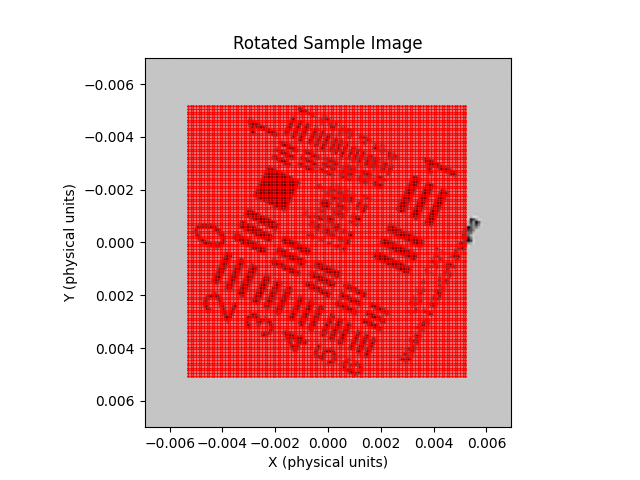

In [8]:
scan_coordinates = ScanGrid.get_coords()

# Set the physical extent (edges) centered around zero
extent = [
    -sample_rotated_edge_length_x/2,
    sample_rotated_edge_length_x/2,
    sample_rotated_edge_length_y/2,
    -sample_rotated_edge_length_y/2,
]

# Reshape the scan coordinates into a 2D grid (centers of pixels).
grid = scan_coordinates.reshape(ScanGrid.scan_shape[0], ScanGrid.scan_shape[1], 2)

plt.figure()
plt.imshow(np.abs(sample_rotated), cmap='gray', extent=extent)
plt.plot(grid[:, :, 1], grid[:, :, 0], 'ro', markersize=1)

plt.title('Rotated Sample Image')
plt.xlabel('X (physical units)')
plt.ylabel('Y (physical units)')
plt.show()

Generating the forward dataset:

In [9]:
fourdstem_array = jnp.zeros((*ScanGrid.scan_shape, *Detector.shape), dtype=jnp.complex64)

scan_coords_yx = ScanGrid.coords.reshape(*ScanGrid.scan_shape, 2)

@jax.jit
def compute_fourdstem_array_forward(model, scan_coords_yx):
    def _project_frame_forward(scan_pos):
        det_frame = jnp.zeros(Detector.shape, dtype=jnp.complex64)
        return project_frame_forward(model, det_frame, sample_interpolant, scan_pos)
    
    # Vectorize over both scan grid axes.
    vmapped_process = jax.vmap(jax.vmap(_project_frame_forward, in_axes=0), in_axes=0)
    return vmapped_process(scan_coords_yx)

fourdstem_array = compute_fourdstem_array_forward(model, scan_coords_yx).block_until_ready()


In [10]:
%timeit compute_fourdstem_array_forward(model, scan_coords_yx).block_until_ready()

42.2 ms ± 144 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


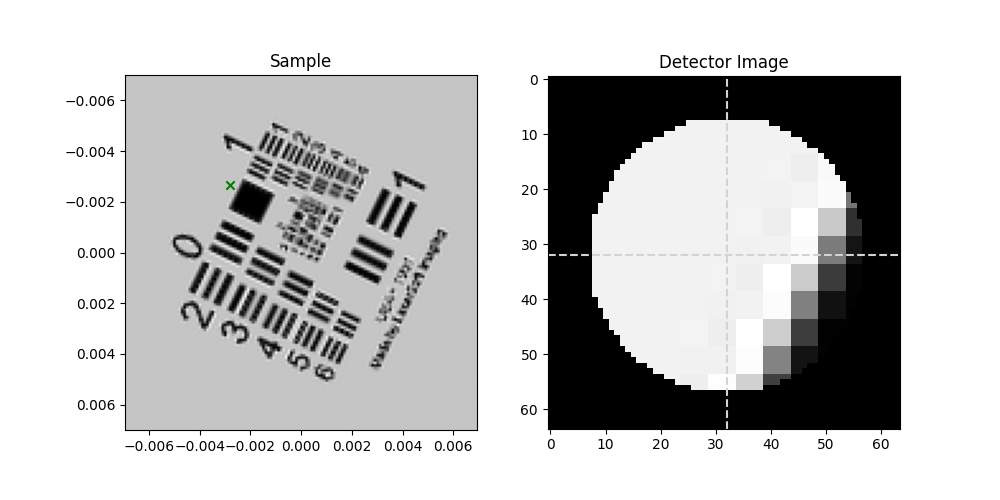

In [11]:
scan_idx_y, scan_idx_x = 25, 25
scan_pos_y, scan_pos_x = scan_coords_yx[scan_idx_y, scan_idx_x]
det_image_selected = fourdstem_array[scan_idx_y, scan_idx_x]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(np.abs(sample_rotated), extent=extent, cmap='gray')
ax[0].scatter(scan_pos_x, scan_pos_y, c='g', marker='x', alpha=1)
ax[0].set_title('Sample')

ax[1].imshow(np.abs(det_image_selected), cmap='gray')
ax[1].axhline(Detector.shape[0]/2, color='lightgrey', linestyle='--')
ax[1].axvline(Detector.shape[1]/2, color='lightgrey', linestyle='--')
ax[1].set_title('Detector Image')
plt.show()

Generate the backward get_shifted_sum solution

In [12]:
@jax.jit
def compute_shifted_sum(model, scan_coords_yx, fourdstem_array):
    def _project_frame_backward(scan_pos, det_frame):
        return project_frame_backward(model, det_frame, scan_pos)
    
    # Vectorize over both scan grid axes.
    vmapped_process = jax.vmap(jax.vmap(_project_frame_backward, in_axes=(0, 0)), in_axes=(0, 0))
    # Sum over all scan points to get the total shifted sum image.
    return vmapped_process(scan_coords_yx, fourdstem_array).sum(axis=(0, 1))

shifted_sum = compute_shifted_sum(model, scan_coords_yx, fourdstem_array).block_until_ready()

It's 10x slower to go backwards, which is bad, we can fix that later. It's probably due to the masking, and making a new image each step. 

In [13]:
%timeit shifted_sum = compute_shifted_sum(model, scan_coords_yx, fourdstem_array).block_until_ready()

586 ms ± 885 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0.5, 1.0, 'Shifted Sum Image')

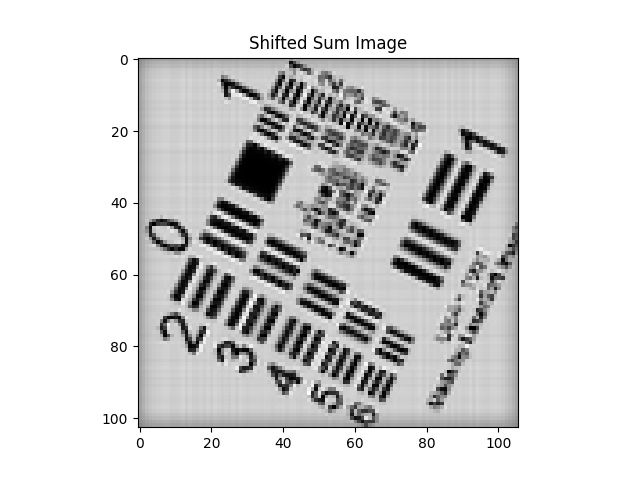

In [14]:
plt.figure()
plt.imshow(np.abs(shifted_sum), cmap='gray')
plt.title('Shifted Sum Image')

Liveplot version

In [ ]:
import panel as pn
pn.extension()

In [ ]:
from libertem_ui.live_plot import ApertureFigure
from bokeh.models.formatters import PrintfTickFormatter

PointSource = comp.PointSource(z=crossover_z, semi_conv=semi_conv)
ScanGrid = comp.ScanGrid(z=jnp.array([params_dict['defocus']]), scan_step=params_dict['scan_px_size'], scan_shape=params_dict['scan_size'], scan_rotation=params_dict['scan_rotation'])
Descanner = comp.Descanner(z=jnp.array([params_dict['defocus']]), descan_error=params_dict['descan_error'], offset_x=0.0, offset_y=0.0)
Detector = comp.Detector(z=jnp.array([params_dict['camera_length']]), shape=params_dict['det_shape'], pixel_size=params_dict['det_px_size'], rotation=0.0)
model = [PointSource, ScanGrid, Descanner, Detector]

input_ray_positions = jnp.array([[0.0, 0.0, 0.0, 0.0, 1.0]])

ray = Ray(
    z=jnp.array([0.0]),
    matrix=input_ray_positions,
    amplitude=jnp.ones(1),
    pathlength=jnp.zeros(1),
    wavelength=jnp.ones(1),
    blocked=jnp.zeros(1, dtype=float)
)

shifted_sum_array = np.random.uniform(size=params_dict['det_shape']).astype(np.complex64)

def run_model_inner(params_dict):
    defocus = params_dict['defocus']
    semi_conv = params_dict['semi_conv']
    camera_length = params_dict['camera_length']
    det_size = params_dict['det_size']
    scan_size = params_dict['scan_size']
    scan_px_size = params_dict['scan_px_size']
    det_px_size = params_dict['det_px_size']
    scan_rotation = params_dict['rotation']
    descan_error = params_dict['descan_error']

    
    PointSource = comp.PointSource(z=crossover_z, 
                                   semi_conv=semi_conv)
    ScanGrid = comp.ScanGrid(z=defocus, 
                             scan_step=scan_px_size, 
                             scan_shape=scan_size, 
                             scan_rotation=scan_rotation)
    Descanner = comp.Descanner(z=defocus, 
                               descan_error=descan_error, 
                               offset_x=0.0, offset_y=0.0)
    Detector = comp.Detector(z=camera_length, 
                             shape=det_size, 
                             pixel_size=det_px_size, 
                             rotation=0.0)
    
    model = [PointSource, ScanGrid, Descanner, Detector]


    shifted_sum_image = compute_shifted_sum(model, scan_coords_yx, fourdstem_array)

    return np.abs(shifted_sum_image)


defocus_slider = pn.widgets.FloatSlider(name="defocus", value=0.001, start=0.001, end=0.1, step=0.001, format=PrintfTickFormatter(format='%.3f m'))
semi_conv_slider = pn.widgets.FloatSlider(name="semi_conv", value=0.01, start=0.01, end=0.1, step=0.001, format=PrintfTickFormatter(format='%.3f slope'))
camera_length_slider = pn.widgets.FloatSlider(name="camera_length", value=1.0, start=0.1, end=10, format=PrintfTickFormatter(format='%.3f m'))
scan_px_size_slider = pn.widgets.FloatSlider(name="scan_px_size", value=0.0001, start=0.0001, end=0.01, step=0.0001, format=PrintfTickFormatter(format='%.4f m'))
det_px_size_slider = pn.widgets.FloatSlider(name="det_px_size", value=.002, start=0.0001, end=0.01, step=0.0001, format=PrintfTickFormatter(format='%.4f m'))
rotation_slider = pn.widgets.FloatSlider(name="rotation", start=0., end=360, step=0.01, value=0.02, format=PrintfTickFormatter(format='%.3f degrees'))

Axx_slider = pn.widgets.FloatSlider(name="Axx", value=4, start=-10, end=10, step=0.1)
Axy_slider = pn.widgets.FloatSlider(name="Axy", value=6, start=-10, end=10, step=0.1)
Ayx_slider = pn.widgets.FloatSlider(name="Ayx", value=-7, start=-10, end=10, step=0.1)
Ayy_slider = pn.widgets.FloatSlider(name="Ayy", value=3, start=-10, end=10, step=0.1)
Cxx_slider = pn.widgets.FloatSlider(name="Cxx", value=-5, start=-10, end=10, step=0.1)
Cxy_slider = pn.widgets.FloatSlider(name="Cxy", value=-3, start=-10, end=10, step=0.1)
Cyx_slider = pn.widgets.FloatSlider(name="Cyx", value=5, start=-10, end=10, step=0.1)
Cyy_slider = pn.widgets.FloatSlider(name="Cyy", value=-4, start=-10, end=10, step=0.1)

figure = (
    ApertureFigure
    .new(shifted_sum_array, tools=False, maxdim=600)
)


def run_model(*e):
    defocus_v = defocus_slider.value
    semi_conv_v = semi_conv_slider.value
    camera_length_v = camera_length_slider.value
    scan_px_size_v = (scan_px_size_slider.value, scan_px_size_slider.value)
    det_px_size_v = det_px_size_slider.value
    rotation_v = rotation_slider.value

    descan_error_v = [Axx_slider.value, Axy_slider.value, Ayx_slider.value, Ayy_slider.value, 
                      Cxx_slider.value, Cxy_slider.value, Cyx_slider.value, Cyy_slider.value]

    params_dict = {
        'defocus': defocus_v,
        'semi_conv': semi_conv_v,
        'camera_length': camera_length_v,
        'scan_size': sample_image_shape,
        'det_size': det_shape,
        'scan_px_size': scan_px_size_v,
        'det_px_size': det_px_size_v,
        'rotation': rotation_v,
        'descan_error': descan_error_v}

    image = run_model_inner(params_dict)
    figure.im.update(image)


defocus_slider.param.watch(run_model, 'value_throttled')
semi_conv_slider.param.watch(run_model, 'value_throttled')
camera_length_slider.param.watch(run_model, 'value_throttled')
scan_px_size_slider.param.watch(run_model, 'value_throttled')
det_px_size_slider.param.watch(run_model, 'value_throttled')
rotation_slider.param.watch(run_model, 'value_throttled')
Axx_slider.param.watch(run_model, 'value_throttled')
Axy_slider.param.watch(run_model, 'value_throttled')
Ayx_slider.param.watch(run_model, 'value_throttled')
Ayy_slider.param.watch(run_model, 'value_throttled')
Cxx_slider.param.watch(run_model, 'value_throttled')
Cxy_slider.param.watch(run_model, 'value_throttled')
Cyx_slider.param.watch(run_model, 'value_throttled')
Cyy_slider.param.watch(run_model, 'value_throttled')

pn.Row(
    pn.Column(
        defocus_slider,
        semi_conv_slider,
        camera_length_slider,
        scan_px_size_slider,
        det_px_size_slider,
        rotation_slider,
        pn.Row(
            pn.Column(
                Axx_slider,
                Axy_slider,
                Ayx_slider,
                Ayy_slider
            ),
            pn.Column(
                Cxx_slider,
                Cxy_slider,
                Cyx_slider,
                Cyy_slider
            )
        )
    ),
    figure.layout
)

ModuleNotFoundError: No module named 'libertem_ui'